In this notebook I will explore the nba shot logs data which can be found here: https://www.kaggle.com/datasets/dansbecker/nba-shot-logs

In [ ]:
# Importing libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import sklearn as sk
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sp
import numpy as np
import imblearn

# Exploring the data

In [ ]:
# Loading in the data
data = pd.read_csv('/content/drive/MyDrive/Datasets/shot_logs.csv')
players = ['lebron james', 'stephen curry', 'kevin durant', 'kobe bryant', 'tim duncan', 'klay thompson', 'kyrie irving', 'carmelo anthony']
data_filtered = data[data['player_name'].isin(players)]
data_filtered = data_filtered[['DRIBBLES', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME', 'SHOT_RESULT']]
data_filtered.describe()

,DRIBBLES,SHOT_DIST,CLOSE_DEF_DIST,TOUCH_TIME
count,5991.000000,5991.000000,5991.000000,5991.000000
mean,3.158738,14.855283,3.849257,3.959239
std,4.222447,8.923614,2.622821,3.680555
min,0.000000,0.100000,0.000000,-4.300000
25%,0.000000,5.700000,2.300000,1.100000
50%,1.000000,16.000000,3.500000,2.900000
75%,5.000000,23.800000,4.800000,5.700000
max,28.000000,45.300000,53.200000,23.300000


From the plot below we can see that the number of dribbles taken by each player is relatively low.


<Axes: ylabel='Frequency'>

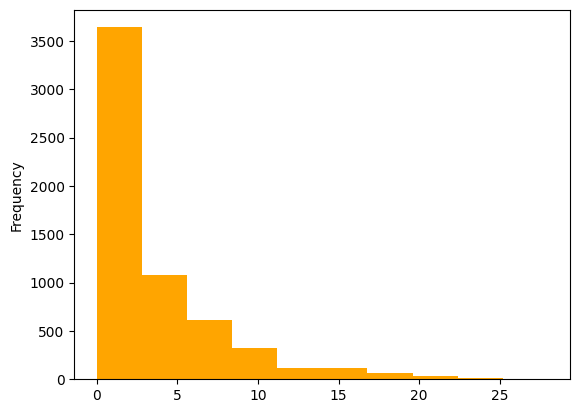

In [ ]:
dribbles = data_filtered['DRIBBLES']
dribbles.plot(kind = 'hist', color = 'orange' )

The scatter matrix below can be confusing, so let me explain some key findings.
1. As the distance from the hoop increases, the number of dribbles decreases.
2. As the defender gets closer to the player, the number of dribbles decreases.
3. As the shot distance increases, the distance of the closest defender decreases

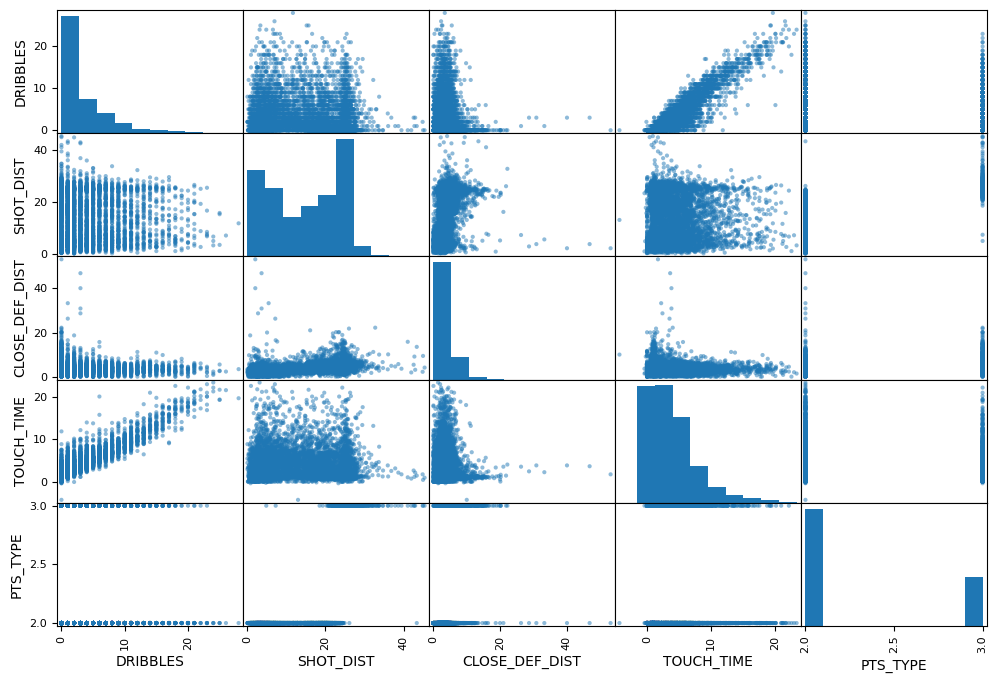

In [ ]:
scatter_matrix(data_filtered, figsize = (12,8))
plt.show()

# Classification model

In [ ]:
# Building the model
X = data_filtered.drop(columns = ['SHOT_RESULT'])
y = data_filtered[['SHOT_RESULT']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [ ]:
# Building the Decison Tree
model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = 7)
model = model.fit(X_train, y_train)
y_predictions = model.predict(X_test)

In [ ]:
# Testing the accuracy of our model
print("Accuracy:", accuracy_score(y_test, y_predictions))

Accuracy: 0.6090100111234705


In [ ]:
# Testing the precision of our model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predictions, target_names=['made', 'missed']))

              precision    recall  f1-score   support

        made       0.66      0.29      0.41       822
      missed       0.60      0.87      0.71       976

    accuracy                           0.61      1798
   macro avg       0.63      0.58      0.56      1798
weighted avg       0.63      0.61      0.57      1798



In [ ]:
np.count_nonzero(data_filtered == 'made')

2762

In [ ]:
np.count_nonzero(data_filtered == 'missed')

3229

# Fixing the class imbalance

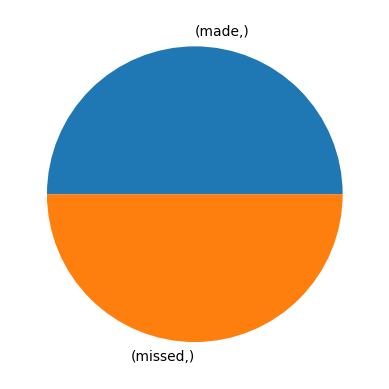

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='not majority')
X_ros, y_ros = ros.fit_resample(X,y)

ax = y_ros.value_counts().plot.pie()


In [ ]:
y_ros.value_counts()

SHOT_RESULT
made           3229
missed         3229
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size = 0.2, random_state = 7)
model = tree.DecisionTreeClassifier(max_depth = 7, random_state = 7)
model = model.fit(X_train, y_train)
y_predictions = model.predict(X_test)
print(classification_report(y_test, y_predictions, target_names=['made', 'missed']))

              precision    recall  f1-score   support

        made       0.64      0.45      0.53       665
      missed       0.56      0.73      0.63       627

    accuracy                           0.59      1292
   macro avg       0.60      0.59      0.58      1292
weighted avg       0.60      0.59      0.58      1292



In [ ]:
param_dist={
    'criterion':['gini', 'entropy'],
    'max_depth':[1,2,3,4,5,6,7,None]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(model, param_grid = param_dist, cv = 10, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=7, random_state=7),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, None]})

In [ ]:
grid.best_score_

0.5880789588112696

# Random Forest Algorithm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size = 0.2, random_state = 7)
model_rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 90, max_features = 2,min_samples_split = 6, random_state = 7)
model_rf = model_rf.fit(X_train, y_train)
y_predictions_rf = model_rf.predict(X_test)
print(classification_report(y_test, y_predictions_rf, target_names=['made', 'missed']))

<ipython-input-84-c8e1975fcc4a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf = model_rf.fit(X_train, y_train)


              precision    recall  f1-score   support

        made       0.67      0.64      0.65       665
      missed       0.63      0.67      0.65       627

    accuracy                           0.65      1292
   macro avg       0.65      0.65      0.65      1292
weighted avg       0.65      0.65      0.65      1292



In [ ]:
print("Accuracy:", accuracy_score(y_test, y_predictions_rf))

Accuracy: 0.6493808049535603


In [ ]:
data_filtered.to_csv('data_filtered.csv')
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

After using multiple algorithms, adjusting the class imbalances and hypertuning the parameters we got an accuracy of 64.9%. In this project we learned that data preprocessing is very important, and machine learning is all about tweaking different things. Now, I will build a web app using the streamlit library. Check out the other files in the GitHub.